**0.1 Intent**

In the following notebook we are going to be performing sentiment analysis on a collection of tweets about Apple Inc. The data can be obtained from the following link. After preprocessing, the tweets are labeled as either positive (i.e. I love my new iphone!) or negative. (i.e. Apple's customer service stinks!) We will conclude this write-up with an analysis of the words that are most indicative of a negative or positive tweet.

In [5]:
import nltk
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
# os.chdir()
df = pd.read_csv('/content/drive/MyDrive/Colab Notebook/data/popcorn_train.csv',header=0, sep='\t', quoting=3)
df.head()


,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [7]:
df=df.drop(['id'],axis=1)
df.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


In [8]:
# def encoder(x):
#   if x==1:
#     return 1
#   else:
#     return 0

# df['sentiment'] = df['sentiment'].apply(encoder)
# df.head()

In [9]:
df['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

# Preprocessing
### Clean the Data

In [10]:

def standardize_text(df, text_field):
    #removes special strings and non text
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df = standardize_text(df, 'review')
# df.to_csv('clean_reviews.csv)
df.head()

,sentiment,review
0,1,"""with all this stuff going down at the moment ..."
1,1,""" ""the classic war of the worlds "" by timothy ..."
2,0,"""the film starts with a manager (nicholas bell..."
3,0,"""it must be assumed that those who praised thi..."
4,1,"""superbly trashy and wondrously unpretentious ..."


### Tokenization

In [11]:
from nltk.tokenize import RegexpTokenizer

tokenizer=RegexpTokenizer(r'\w+')
df['tokens']=df['review'].apply(tokenizer.tokenize)
df.head()

,sentiment,review,tokens
0,1,"""with all this stuff going down at the moment ...","[with, all, this, stuff, going, down, at, the,..."
1,1,""" ""the classic war of the worlds "" by timothy ...","[the, classic, war, of, the, worlds, by, timot..."
2,0,"""the film starts with a manager (nicholas bell...","[the, film, starts, with, a, manager, nicholas..."
3,0,"""it must be assumed that those who praised thi...","[it, must, be, assumed, that, those, who, prai..."
4,1,"""superbly trashy and wondrously unpretentious ...","[superbly, trashy, and, wondrously, unpretenti..."


In [12]:
sentence_len=[len(tokens) for tokens in df['tokens']]
vocab=sorted(list(set(list(word for tokens in df['tokens'] for word in tokens))))

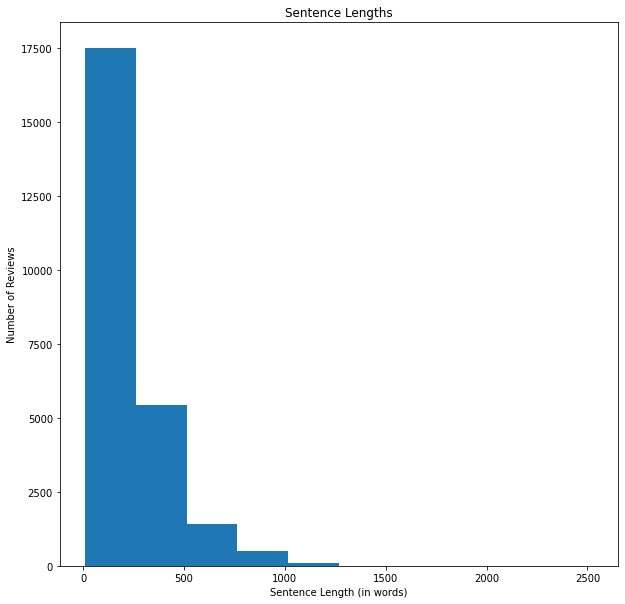

In [13]:
plt.figure(figsize = (10,10))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Reviews')
plt.title('Sentence Lengths')
plt.hist(sentence_len)
plt.show()

In [14]:
print('Words in vocab: ', len(vocab))

Words in vocab:  74533


### Bag of Words


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X=df[['review']]
y=df['sentiment']

#splitting data for cross validation of model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2,shuffle=False)
X_train, X_test = X_train['review'], X_test['review']

# #saving to csv
# X_train.to_csv('train_clean.csv')
# X_test.to_csv('test_clean.csv')
# y_train.to_csv('y_train.csv')
# y_test.to_csv('y_test.csv')

print(X_train[:5])




0    "with all this stuff going down at the moment ...
1    " "the classic war of the worlds " by timothy ...
2    "the film starts with a manager (nicholas bell...
3    "it must be assumed that those who praised thi...
4    "superbly trashy and wondrously unpretentious ...
Name: review, dtype: object


In [16]:
vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)


### Visualization

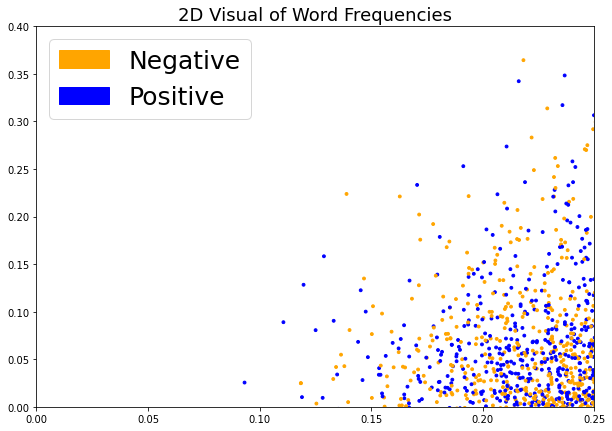

In [17]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_lsa(review, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(review)
    lsa_scores = lsa.transform(review)
    color_dict = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_dict[label] for label in labels]
    colors = ['orange', 'blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Negative')
        green_patch = mpatches.Patch(color='blue', label='Positive')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 25})

fig = plt.figure(figsize =(10,7))
plot_lsa(X_train_tfidf, y_train)
plt.xlim(0,0.25)
plt.ylim(0,0.4)
plt.title("2D Visual of Word Frequencies", size = 18)
plt.show()


# Modelling
### Model Building

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

logr = LogisticRegressionCV()
logr.fit(X_train_tfidf, y_train)
y_pred_logr = logr.predict(X_test_tfidf)

In [19]:

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

clf = SVC(class_weight = 'balanced')
pipe = Pipeline([('classifier', clf)])
fit_params = {'classifier__kernel':['rbf', 'linear', 'poly'],
          'classifier__degree':[2, 3, 4],
          'classifier__C':[0.01, 0.1, 1, 10]}

gs = GridSearchCV(pipe, fit_params, cv = 10, return_train_score = True)
gs.fit(X_train_tfidf, y_train)

print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_, gs.best_params_))

pipe.set_params(classifier__degree = gs.best_params_['classifier__degree'],
                classifier__kernel = gs.best_params_['classifier__kernel'],
               classifier__C = gs.best_params_['classifier__C'])
pipe.fit(X_train_tfidf, y_train)
y_pred = pipe.predict(X_test_tfidf)



KeyboardInterrupt: ignored

### Model Evaluation


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

#Logistic Regression Eval
print('Logistic Regression Accuracy: ', accuracy_score(y_test, y_pred_logr))
print('\nLogistic Classification Report: \n' , classification_report(y_test,  y_pred_logr))

#SVM Eval
print('\n\n SVM Accuracy: ', accuracy_score(y_test, y_pred))
print('\nSVM Classification Report: \n' , classification_report(y_test,  y_pred))


### Confusion Matrix


In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    return plt

cm = confusion_matrix(y_test, y_pred_logr)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)


In [ ]:
# Examples of False Negatives 

def find_fn(ypred, ytrue):
    y_fn  = X_test[(ypred==0)&(ypred!=ytrue)]
    return y_fn

fn = find_fn(y_pred_logr, y_test)
print('Number of False Negatives: ', fn.shape, '\n')
print(fn[:1].values, '\n')
print(fn[1:2].values, '\n')
print(fn[2:3].values, '\n')
print(fn[3:4].values)

# Examples of False Positives (Predicted Pos/ Actual Neg)¶
def find_fp(ypred, ytrue):
    y_fp  = X_test[(ypred==1)&(ypred!=ytrue)]
    return y_fp

fp = find_fp(y_pred_logr, y_test)
print('Number of False Positives: ', fp.shape, '\n')
print(fp[:1].values, '\n')
print(fp[1:2].values, '\n')
print(fp[2:3].values, '\n')
print(fp[3:4].values)

### Word Importances

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vect, logr, 10)

In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Sentiment', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Sentiment', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important Words for Sentiment")

In [ ]:
# code reference: https://harrisonjansma.com/apple